In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from torchinfo import summary
from torch.autograd import Function

In [4]:
def set_seed(seed=0):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs('models_refactored_quant', exist_ok=True)
os.makedirs('results_refactored_quant', exist_ok=True)


Using device: cuda


In [6]:
MNIST_IMG_SIZE = 28
MNIST_INPUT_DIM = MNIST_IMG_SIZE * MNIST_IMG_SIZE
MNIST_OUTPUT_DIM = 10
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
AUGMENT_PAD = 2

TEACHER_HIDDEN = 1200
STUDENT_HIDDEN = 400
TEACHER_DROPOUT_INPUT = 0.0
TEACHER_DROPOUT_HIDDEN = 0.0
STUDENT_DROPOUT_INPUT = 0.0
STUDENT_DROPOUT_HIDDEN = 0.0

BATCH_SIZE = 128
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.9
LR_DECAY_FACTOR = 0.95

EPOCHS_TEACHER = 15
EPOCHS_STUDENT = 15
OPTIMIZER_TYPE = 'SGD' # Use 'Adam' or 'SGD'
PRINT_FREQ = 100

TEMPERATURES_TO_TEST = [1, 5, 10, 20]
DEFAULT_T = 10
ALPHA = 0.5

# Quantization parameters
NUM_BITS = 8


In [7]:
transform_teacher_train = transforms.Compose([
    transforms.RandomCrop(MNIST_IMG_SIZE, padding=AUGMENT_PAD),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])

transform_student_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])


train_val_dataset_teacher = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_teacher_train)
train_val_dataset_student = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_student_test)
test_dataset_student = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_student_test)

num_total = len(train_val_dataset_student)
num_train = int(0.95 * num_total)
num_val = num_total - num_train
train_indices, val_indices = torch.utils.data.random_split(range(num_total), [num_train, num_val])

train_dataset_teacher = Subset(train_val_dataset_teacher, train_indices.indices)
train_dataset_student = Subset(train_val_dataset_student, train_indices.indices)
val_dataset_student = Subset(train_val_dataset_student, val_indices.indices)

print(f"Teacher Training set size: {len(train_dataset_teacher)}")
print(f"Student Training set size: {len(train_dataset_student)}")
print(f"Student Validation set size: {len(val_dataset_student)}")
print(f"Student Test set size: {len(test_dataset_student)}")

train_loader_teacher = DataLoader(train_dataset_teacher, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
train_loader_student = DataLoader(train_dataset_student, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_student = DataLoader(val_dataset_student, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_student = DataLoader(test_dataset_student, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


def get_omitted_digit_loader(original_dataset, omitted_digit, batch_size, shuffle=True):
    """Creates a DataLoader excluding samples of a specific digit."""
    if isinstance(original_dataset, torch.utils.data.Subset):
      base_dataset = original_dataset.dataset
      subset_indices = original_dataset.indices
      indices = [i for i in subset_indices if base_dataset.targets[i] != omitted_digit]
    else:
      indices = [i for i, target in enumerate(original_dataset.targets) if target != omitted_digit]

    subset = Subset(original_dataset, indices)
    print(f"Dataset size after omitting digit {omitted_digit}: {len(subset)}")
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.78MB/s]

Teacher Training set size: 57000
Student Training set size: 57000
Student Validation set size: 3000
Student Test set size: 10000


## 4. Quantization Utilities (STE)

In [8]:
class SymmetricQuantSTE(Function):
    """
    Straight-Through Estimator for Uniform Symmetric Quantization.
    Forward pass applies quantization. Backward pass passes gradients unchanged.
    """
    @staticmethod
    def forward(ctx, input, num_bits):
        if num_bits >= 32:
            return input


        v_max = torch.max(torch.abs(input))
        v_max = v_max if v_max > 1e-8 else torch.tensor(1e-8, device=input.device, dtype=input.dtype)
        n_levels = 2**num_bits
        n_positive_levels = (n_levels // 2) - 1
        delta = v_max / n_positive_levels
        delta = max(delta, 1e-8)
        quantized_output = torch.round(input / delta)
        quantized_output = torch.clamp(quantized_output, -n_positive_levels, n_positive_levels)
        quantized_output = quantized_output * delta

        return quantized_output

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None


## 5. Model Definitions (Student Modified for Quantization)

In [9]:
class TeacherNet(nn.Module):
    def __init__(self, input_dim=MNIST_INPUT_DIM, hidden_units=TEACHER_HIDDEN, output_dim=MNIST_OUTPUT_DIM,
                 dropout_input=TEACHER_DROPOUT_INPUT, dropout_hidden=TEACHER_DROPOUT_HIDDEN):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_dim)
        self.dropout_input_rate = dropout_input
        self.dropout_hidden_rate = dropout_hidden

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=self.dropout_input_rate, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        x = self.fc3(x)
        return x

class StudentNetQuant(nn.Module):
    def __init__(self, input_dim=MNIST_INPUT_DIM, hidden_units=STUDENT_HIDDEN, output_dim=MNIST_OUTPUT_DIM,
                 dropout_input=STUDENT_DROPOUT_INPUT, dropout_hidden=STUDENT_DROPOUT_HIDDEN, num_bits=32):
        super().__init__()
        self.num_bits = num_bits
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_dim)
        self.dropout_input_rate = dropout_input
        self.dropout_hidden_rate = dropout_hidden

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=self.dropout_input_rate, training=self.training)
        quantized_weight_fc1 = SymmetricQuantSTE.apply(self.fc1.weight, self.num_bits)
        x = F.relu(F.linear(x, quantized_weight_fc1, self.fc1.bias))

        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        quantized_weight_fc2 = SymmetricQuantSTE.apply(self.fc2.weight, self.num_bits)
        x = F.linear(x, quantized_weight_fc2, self.fc2.bias)
        return x


## 6. Utility Functions (Evaluation, Loss - Same as before)

In [10]:
def evaluate_accuracy(model: nn.Module, dataloader: DataLoader, device: torch.device, class_specific_digit: int = None):
    """Evaluates model accuracy on the provided dataloader."""
    model.eval()
    correct = 0
    total = 0
    correct_specific = 0
    total_specific = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if class_specific_digit is not None:
                mask = (labels == class_specific_digit)
                total_specific += mask.sum().item()
                correct_specific += (predicted[mask] == labels[mask]).sum().item()

    accuracy = 100 * correct / total
    if class_specific_digit is not None:
        accuracy_specific = 100 * correct_specific / total_specific if total_specific > 0 else 0.0
        return accuracy, accuracy_specific
    else:
        return accuracy

def distillation_loss_fn(student_logits, teacher_logits, hard_labels, temp, alpha):
    """Computes the distillation loss."""
    if alpha < 0 or alpha > 1:
        raise ValueError("alpha must be between 0 and 1")

    soft_loss = 0.0
    if alpha > 0:
        teacher_probs_soft = F.softmax(teacher_logits / temp, dim=1)
        student_log_probs_soft = F.log_softmax(student_logits / temp, dim=1)
        soft_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs_soft, teacher_probs_soft.detach()) * (temp * temp)

    hard_loss = 0.0
    if alpha < 1:
        hard_loss = nn.CrossEntropyLoss()(student_logits, hard_labels)

    total_loss = alpha * soft_loss + (1 - alpha) * hard_loss
    return total_loss

## 7. Requirement 1 & 2: Baseline & Distilled Models (Full Precision)
### 7.2 Train Teacher Model (Reduced Epochs)


In [12]:
teacher_model_path = f'models_refactored_quant/teacher_model_{EPOCHS_TEACHER}ep_final.pth'
results_teacher_path = f'results_refactored_quant/teacher_results_{EPOCHS_TEACHER}ep.npy'
teacher_model_fp = TeacherNet().to(device)
set_seed(42)

if os.path.exists(teacher_model_path):
    print(f"Loading pre-trained teacher model from {teacher_model_path}")
    teacher_model_fp.load_state_dict(torch.load(teacher_model_path, map_location=device))
else:
    print(f"--- Training Teacher Model ({EPOCHS_TEACHER} Epochs) ---")
    if OPTIMIZER_TYPE == 'Adam':
         optimizer = optim.Adam(teacher_model_fp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_TEACHER // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(teacher_model_fp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    criterion = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS_TEACHER):
        teacher_model_fp.train()
        batch_losses = []
        progress_bar = tqdm(train_loader_teacher, desc=f"Teacher Epoch {epoch+1}/{EPOCHS_TEACHER}", leave=False)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = teacher_model_fp(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_train_loss = np.mean(batch_losses)
        epoch_val_acc = evaluate_accuracy(teacher_model_fp, val_loader_student, device)
        print(f"Epoch {epoch+1}/{EPOCHS_TEACHER} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()
    print("--- Finished Teacher Training ---")
    torch.save(teacher_model_fp.state_dict(), teacher_model_path)

teacher_test_accuracy = evaluate_accuracy(teacher_model_fp, test_loader_student, device)
print(f"\nFinal Teacher Model Test Accuracy ({EPOCHS_TEACHER} Epochs): {teacher_test_accuracy:.2f}%")

--- Training Teacher Model (15 Epochs) ---


Teacher Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.6238, Val Acc: 94.93%


Teacher Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.2000, Val Acc: 96.60%


Teacher Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1441, Val Acc: 97.27%


Teacher Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1209, Val Acc: 97.47%


Teacher Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1056, Val Acc: 98.27%


Teacher Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.0920, Val Acc: 98.13%


Teacher Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0839, Val Acc: 98.40%


Teacher Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0773, Val Acc: 98.07%


Teacher Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0712, Val Acc: 98.37%


Teacher Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0664, Val Acc: 98.20%


Teacher Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0615, Val Acc: 98.57%


Teacher Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0583, Val Acc: 98.83%


Teacher Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0554, Val Acc: 98.63%


Teacher Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0538, Val Acc: 98.73%


Teacher Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0517, Val Acc: 98.57%
--- Finished Teacher Training ---

Final Teacher Model Test Accuracy (15 Epochs): 98.58%


### 7.3 Train Student Model Baseline (Full Precision, Reduced Epochs)

In [16]:
student_baseline_model_path = f'models_refactored_quant/student_baseline_{EPOCHS_STUDENT}ep_final.pth'
student_baseline_fp = StudentNetQuant(num_bits=32).to(device) # num_bits=32 -> full precision
set_seed(42)

if os.path.exists(student_baseline_model_path):
    print(f"Loading pre-trained student baseline model from {student_baseline_model_path}")
    student_baseline_fp.load_state_dict(torch.load(student_baseline_model_path, map_location=device))
else:
    print(f"--- Training Student Model Baseline ({EPOCHS_STUDENT} Epochs) ---")
    if OPTIMIZER_TYPE == 'Adam':
         optimizer = optim.Adam(student_baseline_fp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_baseline_fp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    criterion = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS_STUDENT):
        student_baseline_fp.train()
        batch_losses = []
        progress_bar = tqdm(train_loader_student, desc=f"Student BL Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = student_baseline_fp(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_train_loss = np.mean(batch_losses)
        epoch_val_acc = evaluate_accuracy(student_baseline_fp, val_loader_student, device)
        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()
    print("--- Finished Student Baseline Training ---")
    torch.save(student_baseline_fp.state_dict(), student_baseline_model_path)

student_baseline_test_accuracy = evaluate_accuracy(student_baseline_fp, test_loader_student, device)
print(f"\nFinal Student Model Baseline Test Accuracy ({EPOCHS_STUDENT} Epochs): {student_baseline_test_accuracy:.2f}%")


--- Training Student Model Baseline (15 Epochs) ---


Student BL Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.3507, Val Acc: 94.47%


Student BL Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.1554, Val Acc: 96.07%


Student BL Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1104, Val Acc: 96.57%


Student BL Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.0865, Val Acc: 97.37%


Student BL Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.0700, Val Acc: 97.57%


Student BL Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.0591, Val Acc: 97.50%


Student BL Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0505, Val Acc: 97.77%


Student BL Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0437, Val Acc: 97.83%


Student BL Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0387, Val Acc: 97.97%


Student BL Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0342, Val Acc: 97.97%


Student BL Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0311, Val Acc: 98.07%


Student BL Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0279, Val Acc: 97.93%


Student BL Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0254, Val Acc: 97.90%


Student BL Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0232, Val Acc: 98.17%


Student BL Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0215, Val Acc: 98.03%
--- Finished Student Baseline Training ---

Final Student Model Baseline Test Accuracy (15 Epochs): 98.06%


### 7.4 Train Distilled Student (Full Precision, Reduced Epochs)

In [17]:
student_distilled_model_path = f'models_refactored_quant/student_distilled_T{DEFAULT_T}_a{ALPHA}_{EPOCHS_STUDENT}ep_final.pth'
student_distilled_fp = StudentNetQuant(num_bits=32).to(device)
set_seed(42)

teacher_model_fp.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_fp.eval()

if os.path.exists(student_distilled_model_path):
    print(f"Loading pre-trained distilled student model from {student_distilled_model_path}")
    student_distilled_fp.load_state_dict(torch.load(student_distilled_model_path, map_location=device))
else:
    print(f"--- Training Distilled Student (T={DEFAULT_T}, alpha={ALPHA}, {EPOCHS_STUDENT} Epochs) ---")
    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(student_distilled_fp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_distilled_fp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    for epoch in range(EPOCHS_STUDENT):
        student_distilled_fp.train()
        batch_losses = []
        progress_bar = tqdm(train_loader_student, desc=f"Distill FP Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher_model_fp(inputs)
            student_logits = student_distilled_fp(inputs)
            loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_train_loss = np.mean(batch_losses)
        epoch_val_acc = evaluate_accuracy(student_distilled_fp, val_loader_student, device)
        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print("--- Finished Distilled Student Training ---")
    torch.save(student_distilled_fp.state_dict(), student_distilled_model_path)

student_distilled_fp_test_accuracy = evaluate_accuracy(student_distilled_fp, test_loader_student, device)
print(f"\nFinal Distilled Student (FP) Test Accuracy ({EPOCHS_STUDENT} Epochs): {student_distilled_fp_test_accuracy:.2f}%")

--- Training Distilled Student (T=10, alpha=0.5, 15 Epochs) ---


Distill FP Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.3069, Val Acc: 96.63%


Distill FP Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.2815, Val Acc: 97.73%


Distill FP Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1818, Val Acc: 98.17%


Distill FP Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1433, Val Acc: 98.17%


Distill FP Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1212, Val Acc: 98.47%


Distill FP Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1080, Val Acc: 98.53%


Distill FP Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0986, Val Acc: 98.43%


Distill FP Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0914, Val Acc: 98.57%


Distill FP Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0855, Val Acc: 98.57%


Distill FP Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0813, Val Acc: 98.57%


Distill FP Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0778, Val Acc: 98.50%


Distill FP Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0750, Val Acc: 98.63%


Distill FP Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0726, Val Acc: 98.63%


Distill FP Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0705, Val Acc: 98.67%


Distill FP Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0685, Val Acc: 98.60%
--- Finished Distilled Student Training ---

Final Distilled Student (FP) Test Accuracy (15 Epochs): 98.54%


## 7.5 Quantization-Aware Training (QAT) Baseline (No Distillation)
Bit=8

In [13]:
print(f"\n--- Starting Quantization-Aware Training (QAT) Baseline (NumBits={NUM_BITS}, alpha=0) ---")
student_qat_baseline = StudentNetQuant(num_bits=NUM_BITS).to(device)
set_seed(42)

qat_baseline_model_path = f'models_refactored_quant/student_qat_baseline_{NUM_BITS}b_{EPOCHS_STUDENT}ep_final.pth'

if os.path.exists(qat_baseline_model_path):
    print(f"Loading pre-trained QAT baseline model from {qat_baseline_model_path}")
    student_qat_baseline.load_state_dict(torch.load(qat_baseline_model_path, map_location=device))
else:
    print(f"--- Training QAT Baseline Student ({EPOCHS_STUDENT} Epochs) ---")
    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(student_qat_baseline.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_qat_baseline.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    criterion = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS_STUDENT):
        student_qat_baseline.train()
        batch_losses = []
        progress_bar = tqdm(train_loader_student, desc=f"QAT BL Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            student_logits = student_qat_baseline(inputs)
            loss = criterion(student_logits, labels)

            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i + 1) % PRINT_FREQ == 0:
                with torch.no_grad():
                     _, predicted = torch.max(student_logits.data, 1)
                     accuracy = (predicted == labels).float().mean().item()
                progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{accuracy:.3f}")

        epoch_train_loss = np.mean(batch_losses)
        epoch_val_acc = evaluate_accuracy(student_qat_baseline, val_loader_student, device)
        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print("--- Finished QAT Baseline Training ---")
    torch.save(student_qat_baseline.state_dict(), qat_baseline_model_path)

student_qat_baseline_test_accuracy = evaluate_accuracy(student_qat_baseline, test_loader_student, device)

print(f"\n--- QAT Baseline Results (NumBits={NUM_BITS}) ---")
print(f"Student QAT Baseline Test Accuracy:  {student_qat_baseline_test_accuracy:.2f}%")


--- Starting Quantization-Aware Training (QAT) Baseline (NumBits=8, alpha=0) ---
--- Training QAT Baseline Student (15 Epochs) ---


QAT BL Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.3506, Val Acc: 94.13%


QAT BL Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.1557, Val Acc: 96.00%


QAT BL Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1108, Val Acc: 96.97%


QAT BL Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.0870, Val Acc: 97.33%


QAT BL Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.0706, Val Acc: 97.57%


QAT BL Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.0594, Val Acc: 97.73%


QAT BL Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0510, Val Acc: 97.90%


QAT BL Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0442, Val Acc: 98.07%


QAT BL Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0391, Val Acc: 97.83%


QAT BL Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0349, Val Acc: 97.97%


QAT BL Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0315, Val Acc: 98.10%


QAT BL Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0281, Val Acc: 98.17%


QAT BL Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0256, Val Acc: 98.10%


QAT BL Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0235, Val Acc: 98.17%


QAT BL Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0218, Val Acc: 98.17%
--- Finished QAT Baseline Training ---

--- QAT Baseline Results (NumBits=8) ---
Student QAT Baseline Test Accuracy:  97.98%


bit=4

In [14]:
print(f"\n--- Starting Quantization-Aware Training (QAT) Baseline (NumBits={4}, alpha=0) ---")
student_qat_baseline = StudentNetQuant(num_bits=4).to(device)
set_seed(42)

qat_baseline_model_path = f'models_refactored_quant/student_qat_baseline_{4}b_{EPOCHS_STUDENT}ep_final.pth'

if os.path.exists(qat_baseline_model_path):
    print(f"Loading pre-trained QAT baseline model from {qat_baseline_model_path}")
    student_qat_baseline.load_state_dict(torch.load(qat_baseline_model_path, map_location=device))
else:
    print(f"--- Training QAT Baseline Student ({EPOCHS_STUDENT} Epochs) ---")
    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(student_qat_baseline.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_qat_baseline.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS_STUDENT):
        student_qat_baseline.train()
        batch_losses = []
        progress_bar = tqdm(train_loader_student, desc=f"QAT BL Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            student_logits = student_qat_baseline(inputs)
            loss = criterion(student_logits, labels)

            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i + 1) % PRINT_FREQ == 0:
                with torch.no_grad():
                     _, predicted = torch.max(student_logits.data, 1)
                     accuracy = (predicted == labels).float().mean().item()
                progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{accuracy:.3f}")

        epoch_train_loss = np.mean(batch_losses)
        epoch_val_acc = evaluate_accuracy(student_qat_baseline, val_loader_student, device)
        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print("--- Finished QAT Baseline Training ---")
    torch.save(student_qat_baseline.state_dict(), qat_baseline_model_path)
student_qat_baseline_test_accuracy = evaluate_accuracy(student_qat_baseline, test_loader_student, device)

print(f"\n--- QAT Baseline Results (NumBits={4}) ---")
print(f"Student QAT Baseline Test Accuracy:  {student_qat_baseline_test_accuracy:.2f}%")


--- Starting Quantization-Aware Training (QAT) Baseline (NumBits=4, alpha=0) ---
--- Training QAT Baseline Student (15 Epochs) ---


QAT BL Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.3523, Val Acc: 94.00%


QAT BL Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.1571, Val Acc: 96.10%


QAT BL Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1120, Val Acc: 96.93%


QAT BL Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.0884, Val Acc: 97.23%


QAT BL Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.0728, Val Acc: 97.63%


QAT BL Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.0614, Val Acc: 97.87%


QAT BL Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0525, Val Acc: 97.93%


QAT BL Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0457, Val Acc: 98.03%


QAT BL Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0410, Val Acc: 97.93%


QAT BL Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0366, Val Acc: 97.73%


QAT BL Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0331, Val Acc: 98.07%


QAT BL Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0300, Val Acc: 98.07%


QAT BL Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0275, Val Acc: 97.97%


QAT BL Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0251, Val Acc: 98.03%


QAT BL Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0235, Val Acc: 98.07%
--- Finished QAT Baseline Training ---

--- QAT Baseline Results (NumBits=4) ---
Student QAT Baseline Test Accuracy:  98.03%


## 8. Quantized Distillation
bit=8

In [18]:

print(f"\n--- Starting Quantized Distillation (NumBits={NUM_BITS}, T={DEFAULT_T}, alpha={ALPHA}) ---")
student_quant_distilled = StudentNetQuant(num_bits=NUM_BITS).to(device)
set_seed(42)
teacher_model_qd = TeacherNet().to(device)
teacher_model_qd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_qd.eval()
if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_quant_distilled.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_quant_distilled.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

for epoch in range(EPOCHS_STUDENT):
    student_quant_distilled.train()
    batch_losses = []
    progress_bar = tqdm(train_loader_student, desc=f"QuantDist Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_qd(inputs)
        student_logits = student_quant_distilled(inputs)
        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        if (i + 1) % PRINT_FREQ == 0:
            with torch.no_grad():
                 _, predicted = torch.max(student_logits.data, 1)
                 accuracy = (predicted == labels).float().mean().item()
            progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{accuracy:.3f}")

    epoch_train_loss = np.mean(batch_losses)
    epoch_val_acc = evaluate_accuracy(student_quant_distilled, val_loader_student, device)
    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    scheduler.step()

print("--- Finished Quantized Distillation Training ---")
quant_distilled_model_path = f'models_refactored_quant/student_quant_distilled_{NUM_BITS}b_T{DEFAULT_T}_a{ALPHA}_{EPOCHS_STUDENT}ep_final.pth'
torch.save(student_quant_distilled.state_dict(), quant_distilled_model_path)
student_quant_distilled_test_accuracy = evaluate_accuracy(student_quant_distilled, test_loader_student, device)

print(f"\n--- Quantized Distillation Results (NumBits={NUM_BITS}, T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Teacher Model Test Accuracy:                {teacher_test_accuracy:.2f}%")
print(f"Student Baseline (FP) Test Accuracy:        {student_baseline_test_accuracy:.2f}%")
print(f"Student Distilled (FP) Test Accuracy:       {student_distilled_fp_test_accuracy:.2f}%")
print(f"Student Quantized Distilled Test Accuracy:  {student_quant_distilled_test_accuracy:.2f}%")



--- Starting Quantized Distillation (NumBits=8, T=10, alpha=0.5) ---


QuantDist Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.3104, Val Acc: 96.80%


QuantDist Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.2823, Val Acc: 97.90%


QuantDist Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.1832, Val Acc: 98.10%


QuantDist Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1435, Val Acc: 98.40%


QuantDist Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1223, Val Acc: 98.33%


QuantDist Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1085, Val Acc: 98.40%


QuantDist Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0990, Val Acc: 98.43%


QuantDist Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.0918, Val Acc: 98.50%


QuantDist Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0862, Val Acc: 98.40%


QuantDist Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0818, Val Acc: 98.70%


QuantDist Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0784, Val Acc: 98.47%


QuantDist Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0755, Val Acc: 98.50%


QuantDist Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0729, Val Acc: 98.57%


QuantDist Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0708, Val Acc: 98.63%


QuantDist Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0689, Val Acc: 98.50%
--- Finished Quantized Distillation Training ---

--- Quantized Distillation Results (NumBits=8, T=10, alpha=0.5) ---
Teacher Model Test Accuracy:                98.65%
Student Baseline (FP) Test Accuracy:        98.06%
Student Distilled (FP) Test Accuracy:       98.54%
Student Quantized Distilled Test Accuracy:  98.51%


bit=4

In [19]:

print(f"\n--- Starting Quantized Distillation (NumBits={4}, T={DEFAULT_T}, alpha={ALPHA}) ---")

student_quant_distilled = StudentNetQuant(num_bits=4).to(device)
set_seed(42)

teacher_model_qd = TeacherNet().to(device)
teacher_model_qd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_qd.eval()

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_quant_distilled.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_quant_distilled.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

for epoch in range(EPOCHS_STUDENT):
    student_quant_distilled.train()
    batch_losses = []
    progress_bar = tqdm(train_loader_student, desc=f"QuantDist Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_qd(inputs)
        student_logits = student_quant_distilled(inputs)
        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        if (i + 1) % PRINT_FREQ == 0:
            with torch.no_grad():
                 _, predicted = torch.max(student_logits.data, 1)
                 accuracy = (predicted == labels).float().mean().item()
            progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{accuracy:.3f}")

    epoch_train_loss = np.mean(batch_losses)
    epoch_val_acc = evaluate_accuracy(student_quant_distilled, val_loader_student, device)
    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    scheduler.step()

print("--- Finished Quantized Distillation Training ---")
quant_distilled_model_path = f'models_refactored_quant/student_quant_distilled_{4}b_T{DEFAULT_T}_a{ALPHA}_{EPOCHS_STUDENT}ep_final.pth'
torch.save(student_quant_distilled.state_dict(), quant_distilled_model_path)

student_quant_distilled_test_accuracy = evaluate_accuracy(student_quant_distilled, test_loader_student, device)

print(f"\n--- Quantized Distillation Results (NumBits={4}, T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Teacher Model Test Accuracy:                {teacher_test_accuracy:.2f}%")
print(f"Student Baseline (FP) Test Accuracy:        {student_baseline_test_accuracy:.2f}%")
print(f"Student Distilled (FP) Test Accuracy:       {student_distilled_fp_test_accuracy:.2f}%")
print(f"Student Quantized Distilled Test Accuracy:  {student_quant_distilled_test_accuracy:.2f}%")



--- Starting Quantized Distillation (NumBits=4, T=10, alpha=0.5) ---


QuantDist Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.3130, Val Acc: 96.67%


QuantDist Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.3051, Val Acc: 97.63%


QuantDist Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.2089, Val Acc: 97.93%


QuantDist Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1719, Val Acc: 97.97%


QuantDist Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1500, Val Acc: 98.13%


QuantDist Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1377, Val Acc: 98.10%


QuantDist Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.1290, Val Acc: 98.23%


QuantDist Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.1214, Val Acc: 98.33%


QuantDist Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.1176, Val Acc: 98.13%


QuantDist Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.1143, Val Acc: 98.23%


QuantDist Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.1104, Val Acc: 98.23%


QuantDist Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.1085, Val Acc: 98.27%


QuantDist Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.1060, Val Acc: 98.20%


QuantDist Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.1054, Val Acc: 98.10%


QuantDist Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.1038, Val Acc: 98.07%
--- Finished Quantized Distillation Training ---

--- Quantized Distillation Results (NumBits=4, T=10, alpha=0.5) ---
Teacher Model Test Accuracy:                98.65%
Student Baseline (FP) Test Accuracy:        98.06%
Student Distilled (FP) Test Accuracy:       98.54%
Student Quantized Distilled Test Accuracy:  98.35%


In [20]:

print(f"\n--- Starting Quantized Distillation (NumBits={2}, T={DEFAULT_T}, alpha={ALPHA}) ---")
student_quant_distilled = StudentNetQuant(num_bits=2).to(device)
set_seed(42)
teacher_model_qd = TeacherNet().to(device)
teacher_model_qd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_qd.eval()

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_quant_distilled.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_quant_distilled.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

for epoch in range(EPOCHS_STUDENT):
    student_quant_distilled.train()
    batch_losses = []
    progress_bar = tqdm(train_loader_student, desc=f"QuantDist Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_qd(inputs)
        student_logits = student_quant_distilled(inputs)
        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)

        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        if (i + 1) % PRINT_FREQ == 0:
            with torch.no_grad():
                 _, predicted = torch.max(student_logits.data, 1)
                 accuracy = (predicted == labels).float().mean().item()
            progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{accuracy:.3f}")

    epoch_train_loss = np.mean(batch_losses)

    epoch_val_acc = evaluate_accuracy(student_quant_distilled, val_loader_student, device)
    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    scheduler.step()

print("--- Finished Quantized Distillation Training ---")

quant_distilled_model_path = f'models_refactored_quant/student_quant_distilled_{2}b_T{DEFAULT_T}_a{ALPHA}_{EPOCHS_STUDENT}ep_final.pth'
torch.save(student_quant_distilled.state_dict(), quant_distilled_model_path)

student_quant_distilled_test_accuracy = evaluate_accuracy(student_quant_distilled, test_loader_student, device)

print(f"\n--- Quantized Distillation Results (NumBits={2}, T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Teacher Model Test Accuracy:                {teacher_test_accuracy:.2f}%")
print(f"Student Baseline (FP) Test Accuracy:        {student_baseline_test_accuracy:.2f}%")
print(f"Student Distilled (FP) Test Accuracy:       {student_distilled_fp_test_accuracy:.2f}%")
print(f"Student Quantized Distilled Test Accuracy:  {student_quant_distilled_test_accuracy:.2f}%")



--- Starting Quantized Distillation (NumBits=2, T=10, alpha=0.5) ---


QuantDist Epoch 1/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 6.9493, Val Acc: 38.67%


QuantDist Epoch 2/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 8.1241, Val Acc: 28.93%


QuantDist Epoch 3/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 10.0173, Val Acc: 38.17%


QuantDist Epoch 4/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 9.5585, Val Acc: 16.27%


QuantDist Epoch 5/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 11.4893, Val Acc: 10.47%


QuantDist Epoch 6/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 11.7838, Val Acc: 10.47%


QuantDist Epoch 7/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 11.8393, Val Acc: 10.47%


QuantDist Epoch 8/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 11.7697, Val Acc: 10.23%


QuantDist Epoch 9/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 11.8394, Val Acc: 10.47%


QuantDist Epoch 10/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 11.8383, Val Acc: 10.47%


QuantDist Epoch 11/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 11.7987, Val Acc: 10.47%


QuantDist Epoch 12/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 11.7398, Val Acc: 10.47%


QuantDist Epoch 13/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 11.8364, Val Acc: 10.47%


QuantDist Epoch 14/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 11.8366, Val Acc: 10.47%


QuantDist Epoch 15/15:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 11.8389, Val Acc: 10.47%
--- Finished Quantized Distillation Training ---

--- Quantized Distillation Results (NumBits=2, T=10, alpha=0.5) ---
Teacher Model Test Accuracy:                98.65%
Student Baseline (FP) Test Accuracy:        98.06%
Student Distilled (FP) Test Accuracy:       98.54%
Student Quantized Distilled Test Accuracy:  10.10%


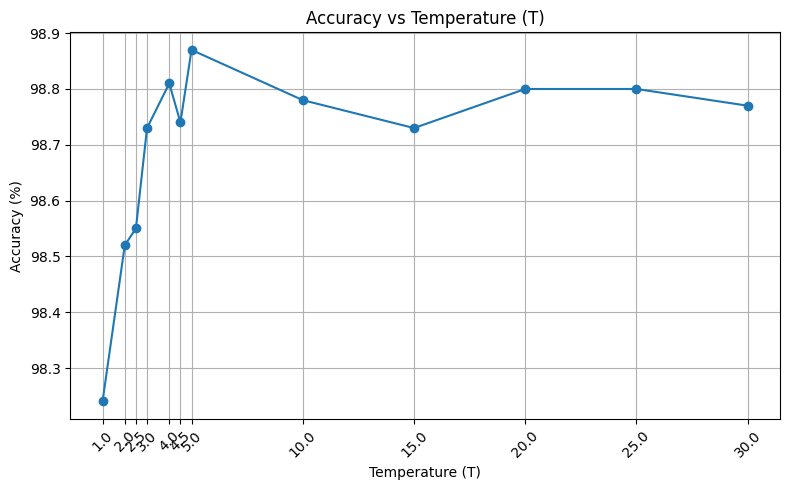

In [21]:
import matplotlib.pyplot as plt


data = [
    (1, 98.24, 0.08),
    (2, 98.52, 0.36),
    (2.5, 98.55, 0.39),
    (3, 98.73, 0.57),
    (4, 98.81, 0.65),
    (4.5, 98.74, 0.58),
    (5, 98.87, 0.71),
    (10, 98.78, 0.62),
    (15, 98.73, 0.57),
    (20, 98.80, 0.64),
    (25, 98.80, 0.64),
    (30, 98.77, 0.61),
]

# Split data
T, accuracy, improvement = zip(*data)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(T, accuracy, marker='o')
plt.title('Accuracy vs Temperature (T)')
plt.xlabel('Temperature (T)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(T, rotation=45)
plt.tight_layout()
plt.show()
